In [26]:
from brian2 import *
import pandas as pd

start_scope()
defaultclock.dt =  1*ms


In [27]:
path = "../data/spike_matrix.csv"
df = pd.read_csv(path, header=0)

tcol = df.iloc[:, 0].to_numpy(dtype=np.float32)
X = df.iloc[:, 1:].to_numpy(dtype=bool)
del df

T, N = X.shape
print(f"T (time bins): {T}, N (neurons): {N}")

T (time bins): 1800001, N (neurons): 50


In [28]:
simulation_duration = T * defaultclock.dt

# parametry dla neuronów i synaps
Cm = 200 *pF   # Membrane capacitance 
k = 0.04 /mV /mV # Nonlinear growth constant
E_L = -70 * mV # Resting membrane potential
v_t = -50 * mV # Threshold voltage
E_m = -60 * mV  # Reference voltage (often same as E_L)
a = 0.02 
b = 0.02 * 1/mV
c = -65 * mV
d = 8 

# STDP
taupre = 20 * ms
taupost = taupre
gmax = 0.01
dApre = 0.01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax
taux = 1000 * ms
tauy = 200 * ms
taus = 1 * ms


In [29]:
#SpikeGeneratorGroup
bin_idx, neuron_idx = np.nonzero(X)  # Wszystkie spiki
spike_times = (bin_idx.astype(np.int64)) * ms
spike_indices = neuron_idx.astype(np.int32)
G = SpikeGeneratorGroup(N, indices=spike_indices, times=spike_times)

In [30]:
#neurony
eqs = """
dv_m/dt = ((k*(v_m - E_L)*(v_m - v_t) - u + I_syn) /Cm /ms) : volt
du/dt = a*(b*(v_m - E_m) - u)/ms : 1
I_syn : 1
"""
neurons = NeuronGroup(N, eqs, threshold='v_m >= v_t', reset='v_m = c; u += d', method='euler')

# inicjujemy zmienne 
neurons.v_m = c
neurons.u = b * neurons.v_m

#monitorowanie
neurons_monitor = SpikeMonitor(neurons)

In [31]:
synapse = Synapses(G, neurons,
                   model='''s: volt''',
                   on_pre='v_m += s')
synapse.connect(j='i')
synapse.s = 100. * mV

In [32]:
# Synapsy z STDP
synapse_stdp = Synapses(neurons, neurons,
                        model='''
                            mode : 1
                            dx/dt = -x / taux : 1 (clock-driven)
                            dy/dt = -y / tauy : 1 (clock-driven)
                            ds/dt = mode * x * y / taus : 1 (clock-driven)
                            dApre/dt = -Apre / taupre : 1 (event-driven)
                            dApost/dt = -Apost / taupost : 1 (event-driven)
                        ''',
                        on_pre='''
                            u += s
                            Apre += dApre
                            x = clip(x + mode * Apost, -gmax, gmax)
                            s = clip(s + (1 - mode) * Apost, -gmax, gmax)
                        ''',
                        on_post='''
                            Apost += dApost
                            x = clip(x + mode * Apre, -gmax, gmax)
                            s = clip(s + (1 - mode) * Apre, -gmax, gmax)
                        ''', 
                        method='euler')

synapse_stdp.connect(j='i')
synapse_stdp.mode = 1
synapse_stdp.s = 1e-10  # wagi początkowe
synapse_stdp.x = 1e-10 
synapse_stdp.y = 0


In [33]:
run(simulation_duration)

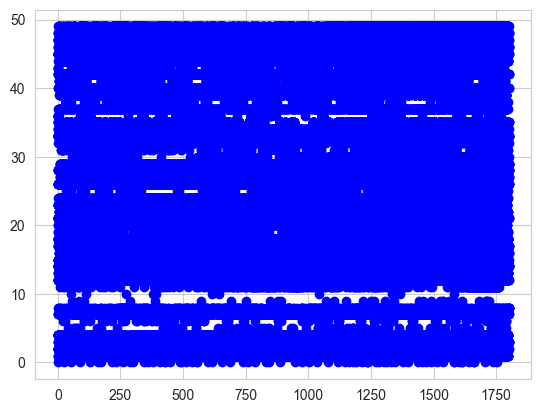

In [34]:
neurons_indices, neurons_times = neurons_monitor.it
plot(neurons_times, neurons_indices, 'ob')

In [35]:
dt_s = 0.001   
T_s = 1800             
N = 50             
T_bins = int(T_s / dt_s) 

raster = np.zeros((T_bins, N), dtype=int)

t_s = np.array(neurons_monitor.t / second)  
i_idx = np.array(neurons_monitor.i)       

for idx, t in zip(i_idx, t_s):
    tbin = int(np.floor(t / dt_s))
    if tbin < T_bins:
        raster[tbin, idx] = 1

time_s = np.arange(T_bins) * dt_s
df = pd.DataFrame(raster, columns=[f"neuron_{i}" for i in range(1, N+1)])
df.insert(0, "time_s", time_s)

In [36]:
df.to_csv("../data/spike_generated.csv", index=True)